# Facial Expression Recognition Using CNN

In [2]:
import os #İşletim sistemi işlevlerini kullanabilme
import cv2 #OpenCV kütüphanesini içe aktarma, görüntü işleme işlevleri
import numpy as np #Çok boyutlu diziler ve matematiksel işlemler
import tensorflow #Derin öğrenme modelleri oluşturma ve eğitme
from sklearn.model_selection import train_test_split #Veri setini eğitim ve test setlerine ayırmak için kullanılan fonksiyon
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Görüntü verilerini işlemek için kullanılan ImageDataGenerator sınıfını içe aktarma
from sklearn.preprocessing import LabelEncoder #Kategorik-metinsel verileri sayısal değerlere dönüştürmek için kullanılan sınıf
from keras.utils import to_categorical #Kategorik etiketleri ikili (binary) matris biçimine dönüştürmek için kullanılan sınıf
from keras.models import Sequential #Ardışık (sequential) bir model oluşturmak için kullanılan sınıf
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten #Modelde kullanılan katman türlerini içe aktarma
from keras.optimizers import Adam, RMSprop, SGD #Modelin optimize edici (optimizer) fonksiyonlarını içe aktarma
import matplotlib.pyplot as plt #Veri görselleştirme, grafikler oluşturma
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau #Model performansını izleme ve iyileştirme

In [4]:
# Veri Seti Kümesi
data_dir = "C:\\Users\\pc\\Desktop\\DerinOgrenmeProje\\images1\\train"
#Eğitim için kullanılacak görüntülerin bulunduğu dizin

In [5]:
# Sınıflar
sub_folders = os.listdir(data_dir) # Belirtilen dizindeki dosya ve dizinleri listeler
#Bu, alt dizinlerin adlarını (happy, angry) içerecektir.

In [6]:
# Görüntüleri ve etiketleri saklamak için boş listeler oluşturuldu
images = [] #Görüntülerin piksel değerlerini saklamak için oluşturulan boş bir liste
labels = [] #Görüntülere karşılık gelen etiketleri saklamak için oluşturulan boş bir liste.

In [7]:
#Her sınıfa ait görüntüler yüklenir ve etiketlenmesi için işlem yapılır.
# Etiketlere ulaşma
for sub_folder in sub_folders:
    label = sub_folder #label değişkenine sınıf adı atanır.

    # Şu anki alt dizine giden yol oluşturuluyor
    path = os.path.join(data_dir, sub_folder)

    # Şu anki alt dizindeki tüm görüntüler listeleniyor
    sub_folder_images = os.listdir(path) #Mevcut alt dizin içindeki tüm görüntülerin listesi sub_folder_images olarak alınır.

     # Görüntülere Erişme
    for image_name in sub_folder_images:
        # Şu anki görüntüye giden yol oluşturuluyor
        image_path = os.path.join(path, image_name)
        # OpenCV kullanılarak görüntü yükleniyor (Gri tonlamalı olarak okunuyor)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        # Görüntü, görüntü listesine ekleniyor
        images.append(img)
        # Şu anki alt dizine karşılık gelen etiket, etiket listesine ekleniyor
        labels.append(label)

In [8]:
# Resim ve etiket listelerini NumPy dizilerine dönüştürme
images = np.array(images)
labels = np.array(labels)
print(len(images))

11157


In [9]:
# Splitting Dataset into training, validation, and test sets
# Veri kümesini eğitim, doğrulama ve test kümelerine bölme
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42) #veri setinin %10'unun doğrulama setine ayrılacağı belirtilir

In [10]:
# Preprocess the image
#Görüntülerin önişleme (preprocessing) işlemleri
def preprocessing(img):
    img = img / 255.0  #Görüntü piksellerini [0, 1] aralığına ölçekler (img / 255.0), böylece piksel değerleri 0 ile 1 arasında olur.
    img = cv2.resize(img, (48, 48))  #Görüntü boyutunu (48, 48) piksele yeniden boyutlandırır
    return img.reshape(-1, 48, 48, 1)  # Reshape to match input shape #Görüntüyü CNN modeline giriş olarak verebilmek için şeklini yeniden düzenler

In [11]:
# Apply preprocessing to training, validation, and test sets
#preprocessing fonksiyonunu eğitim, doğrulama ve test setlerine uygulama
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))
#Bu işlem, setlerin piksel değerlerini ölçekler, boyutlarını yeniden boyutlandırır ve modelin girişine uygun hale getirir. Böylece, bu setler modelin eğitimi ve değerlendirmesi için hazır hale gelir.

In [12]:
# Reshape input data to remove unnecessary dimension
#Yeniden şekillendirme ile gereksiz boyut kaldırma
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)
#Bu işlem, modelin girişine uygun veri yapısını sağlar ve gereksiz boyutları kaldırarak işlemi basitleştirir.

In [13]:
# Initialize ImageDataGenerator for data augmentation
data_gen = ImageDataGenerator(
    width_shift_range=0.1, #Görüntüleri yatay ve dikey olarak kaydırmak için kullanılır.
    height_shift_range=0.1, #Görüntüleri yatay ve dikey olarak kaydırmak için kullanılır.
    zoom_range=0.1, #Görüntüleri yakınlaştırmak veya uzaklaştırmak için kullanılır.
    shear_range=0.1, #Görüntüyü şekillendirerek eğiklik (shear) ekler.
    rotation_range=10 #Görüntüyü belirli bir açıda döndürmek için kullanılır
)

# Compute necessary statistics for data augmentation
data_gen.fit(X_train) #ImageDataGenerator'ın veri seti üzerinde istatistikleri hesaplamasını sağlar

#Bu kod parçası, veri artırma (data augmentation) için ImageDataGenerator sınıfını başlatır ve yapılandırır. Veri artırma, eğitim sırasında mevcut veri setinin çeşitlendirilmesini sağlar, böylece model genelleştirme yeteneğini artırabilir.

In [14]:
# Encode the class labels
#sınıf etiketlerini sayısal değerlere dönüştürme (örn:0-1 gibi)
label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

In [15]:
# Encode the class labels for training, validation, and test sets
#eğitim, doğrulama ve test setlerindeki sınıf etiketlerini sayısal değerlere dönüştürmek için LabelEncoder'ı kullanır. 
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
#transform() yöntemi, verilen sınıf etiketlerini dönüştürmek için fit() yöntemiyle oluşturulan dönüşüm tablosunu kullanır.

In [16]:
# Get the number of classes
num_classes = len(label_encoder.classes_) #Sınıf sayısını alır.

# Convert encoded class labels to one-hot encoded categorical arrays
# to_categorical() Verilen sınıf etiketlerini one-hot encoding formatına dönüştürür.
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

In [17]:
# Building Model
#CNN Modeli oluşturma
def build_model():
    model = Sequential()
    # 1st Layer
    model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(48, 48, 1))) 
    #Evrişim katmanı, görüntüler üzerinde evrişim işlemini uygular
    model.add(BatchNormalization()) 
    # Batch normalization katmanı, her bir öğrenme adımında girdi verilerinin normalleştirilmesini sağlar, bu da daha hızlı ve daha kararlı bir eğitim süreci sağlar.
    model.add(MaxPooling2D(2, 2)) 
    #Toplama katmanı, veri boyutunu azaltmak ve önemli özellikleri vurgulamak için maksimum değeri alarak özellik haritasını küçültür.
    model.add(Dropout(0.3)) 
    #Ağın overfitting'e (aşırı uyuma) karşı daha dirençli olmasını sağlamak için belirtilen oranda nöronları rastgele kapatır.

    # 2nd Layer
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 3rd layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 4th layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # Flatten Layer
    #Düzleştirme katmanı, 3 boyutlu verileri (örneğin, görüntüler) 1 boyutlu vektörlere dönüştürür, böylece tam bağlantılı katmanlara giriş yapılabilir.
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(256, activation='relu')) #(Dense)Tam bağlantılı (fully connected) katmanlar, nöronların bir önceki katmandaki tüm nöronlarla bağlantılı olduğu katmanlardır.
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Fully connected layer 2
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax')) #(softmax)Çoklu sınıf sınıflandırması için kullanılan bir aktivasyon fonksiyonu

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [18]:
# Build the model
model = build_model()

# Print model summary
print(model.summary())

#Model oluşturulur ve model özeti yazdırılır.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

In [19]:
# Initialize ModelCheckpoint callback
# checkpoint = ModelCheckpoint("model.h5", monitor="val_acc", verbose=1, save_best_only=True)
# Initialize ModelCheckpoint callback
checkpoint = ModelCheckpoint("model.keras", monitor="val_acc", verbose=1, save_best_only=True)

In [20]:
# Initialize EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

In [21]:
# Initialize ReduceLROnPlateau callback
reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

In [22]:
# List of callbacks
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

In [23]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [24]:
# Training the model
history = model.fit(
    data_gen.flow(X_train, y_train_categorical, batch_size=128),
    validation_data=(X_val, y_val_categorical),
    epochs=50,
    verbose=1
)

Epoch 1/50
63/63 [==============================] - 98s 2s/step - loss: 0.8900 - accuracy: 0.5778 - val_loss: 1.2365 - val_accuracy: 0.6495
Epoch 2/50
63/63 [==============================] - 89s 1s/step - loss: 0.7458 - accuracy: 0.6154 - val_loss: 1.4320 - val_accuracy: 0.6495
Epoch 3/50
63/63 [==============================] - 93s 1s/step - loss: 0.6829 - accuracy: 0.6414 - val_loss: 1.4727 - val_accuracy: 0.6495
Epoch 4/50
63/63 [==============================] - 91s 1s/step - loss: 0.6288 - accuracy: 0.6706 - val_loss: 1.1032 - val_accuracy: 0.6495
Epoch 5/50
63/63 [==============================] - 92s 1s/step - loss: 0.5573 - accuracy: 0.7242 - val_loss: 1.3463 - val_accuracy: 0.3539
Epoch 6/50
63/63 [==============================] - 88s 1s/step - loss: 0.4957 - accuracy: 0.7608 - val_loss: 0.7079 - val_accuracy: 0.5722
Epoch 7/50
63/63 [==============================] - 87s 1s/step - loss: 0.4546 - accuracy: 0.7862 - val_loss: 1.0494 - val_accuracy: 0.6652
Epoch 8/50
63/63 [==

In [25]:
# Save the model with .keras extension
model.save("modelv2.keras")

In [26]:
# Saving the model with .h5 extension
model.save('modelv2.h5')

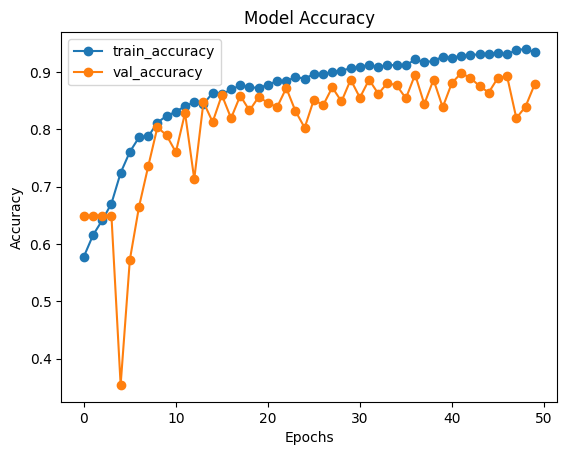

In [27]:
# Plotting model performance
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical, verbose=0)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8830645084381104


In [ ]:
import cv2

# Load the saved model
model = tensorflow.keras.models.load_model("modelv2.keras")

# Initialize the webcam
#bir kamera nesnesi oluşturulur
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
#Webcam'in doğru şekilde açılıp açılmadığını kontrol etmek için cap.isOpened() kullanılır.
if not cap.isOpened():
    print("Error: Could not open webcam")
    exit()

# Define a function to preprocess the webcam image
# bu fonksiyon webcam'den alınan her kareyi modele giriş olarak uygun hale getirir
def preprocess_webcam_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Renkli görüntüyü (BGR) gri tonlamalıya dönüştürme
    img = cv2.resize(img, (48, 48))  # Görüntüyü modele uygun boyuta yeniden boyutlandırma
    img = img / 255.0  # Görüntüyü normalleştirme 
    img = img.reshape(-1, 48, 48, 1)  # Görüntüyü modelin beklediği giriş şekline dönüştürme
    return img

#  webcam'den sürekli olarak görüntü yakalama ve işleme
while True:
    ret, frame = cap.read()  # bir kare okunur
    if not ret:
        print("Error: Could not read frame")
        break

    # Preprocess the frame
    preprocessed_frame = preprocess_webcam_image(frame) #kareyi ön işleme tabi tutar.

    # Use the model to make predictions
    predictions = model.predict(preprocessed_frame) # Ön işlenmiş kare üzerinde tahminler yapar.

    # Get the predicted class
    predicted_class = label_encoder.inverse_transform([np.argmax(predictions)]) #Tahmin edilen sınıfı ve indeksini alır, sınıf etiketine dönüştürür.

    # Display the frame with the predicted class
    #Tahmin edilen sınıfı kameradan alınan görüntünün üzerine yazdırır.
    cv2.putText(frame, predicted_class[0], (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Webcam', frame) #Görüntüyü ekranda gösterir.

    # Check for the 'q' key to exit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'): # 'q' tuşuna basıldığında döngüyü sonlandırır.
        break

# Release the webcam and close the OpenCV windows
cap.release() #Kamera kaynaklarını serbest bırakır.
cv2.destroyAllWindows() #Tüm OpenCV pencerelerini kapatır.





1/1 [==============================] - 0s 63ms/step
